In [103]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi
from itertools import combinations
import numpy as np
import nibabel as nib
from nibabel.orientations import axcodes2ornt, ornt_transform, apply_orientation, aff2axcodes
from nipype.interfaces import fsl   #### SKULL STRIPPING

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress


# Dataset used

Dataset: UNC Paired 3T-7T MRI Dataset

Data Descriptor: Chen, X., Qu, L., Xie, Y. et al. A paired dataset of T1- and T2-weighted MRI at 3 Tesla and 7 Tesla. Sci Data 10, 489 (2023). https://doi.org/10.1038/s41597-023-02400-y

Link: https://springernature.figshare.com/articles/dataset/UNC_Paired_3T-7T_Dataset/23706033?backTo=%2Fcollections%2FA_paired_dataset_of_T1-_and_T2-weighted_MRI_at_3_Tesla_and_7_Tesla%2F6485272&file=41605158

In [17]:
import os, shutil

# Set the FSL base directory
os.environ["FSLDIR"] = "/home/barsa/fsl"

# Add the correct bin path (the one containing bet)
os.environ["PATH"] = "/home/barsa/fsl/share/fsl/bin:" + os.environ["PATH"]

# Verify the path
print("BET path:", shutil.which("bet"))
os.system("bet --version")


BET path: /home/barsa/fsl/share/fsl/bin/bet

Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R         

256

# 1. Load NIfTI files for T1 and T2

In [18]:
#Load NIfti files
T1_S1 = nib.load(r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/sub-04_ses-1_T1w_defaced.nii.gz")
T2_S1 = nib.load(r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/sub-04_ses-1_T2w_defaced.nii.gz")

In [90]:
# Convert it into Numpy Array
T1_sub1 = nib.load(r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/sub-04_ses-1_T1w_defaced.nii.gz").get_fdata()
T2_sub1 = nib.load(r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/sub-04_ses-1_T2w_defaced.nii.gz").get_fdata()

In [20]:
# Check shapes(Number of Slices in Sagittal, Coronal and Axial axes)
T1_sub1_shape = T1_sub1.shape
T2_sub1_shape = T2_sub1.shape
print(T1_sub1_shape, T2_sub1_shape)

(208, 320, 320) (208, 320, 320)


In [21]:
# Check Orientation of the images
affine_t1 = T1_S1.affine
orientation_t1 = aff2axcodes(affine_t1)
affine_t2 = T2_S1.affine
orientation_t2 = aff2axcodes(affine_t2)

print(orientation_t1, orientation_t2)

('R', 'A', 'S') ('R', 'A', 'S')


# Visulaize the MR Images

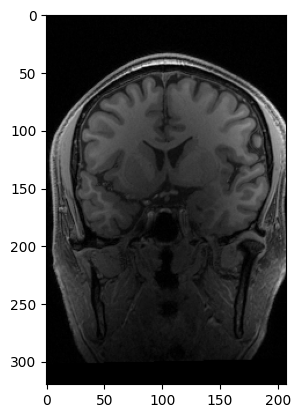

In [22]:
# Coronal Slice of T1
plt.imshow(ndi.rotate(T1_sub1[:,180,:],90), cmap="gray")

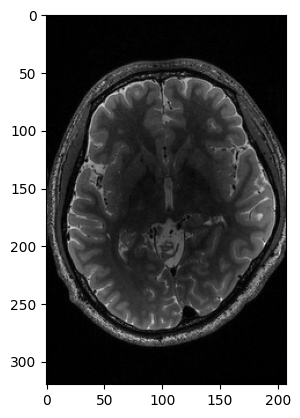

In [23]:
# Axinal Slice of T2
plt.imshow(ndi.rotate(T2_sub1[:,:,180],90), cmap="gray")

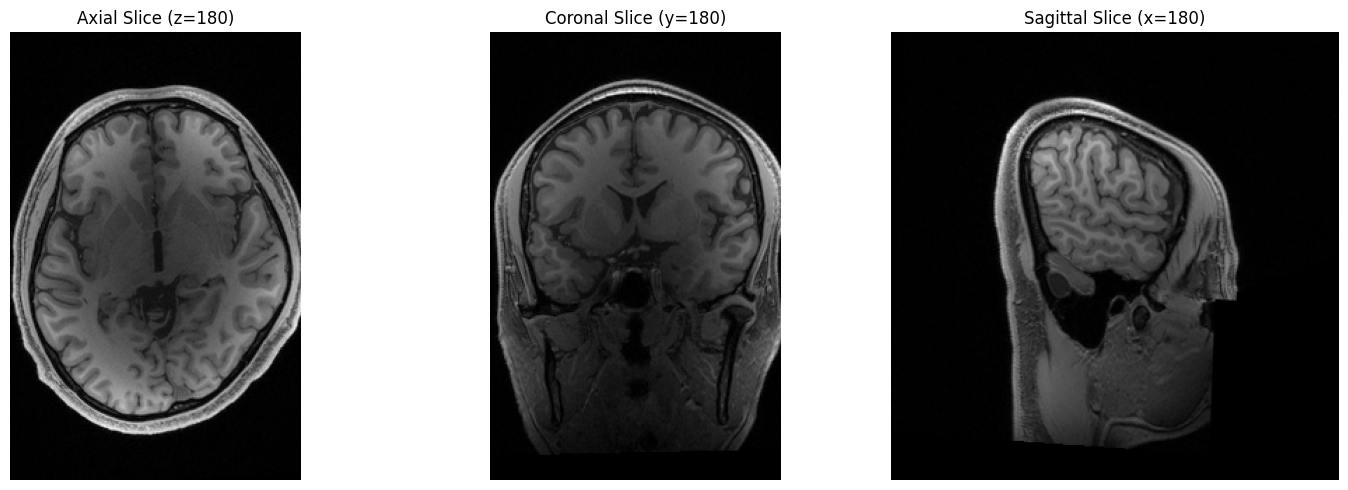

In [24]:
# 180th slice along all the axis for T1

# Axial plane 
axial_slice = ndi.rotate(T1_sub1[:, :, 180], 90)

# Coronal plane 
coronal_slice = ndi.rotate(T1_sub1[:, 180, :], 90)

# Sagittal plane 
sagittal_slice = ndi.rotate(T1_sub1[180, :, :], 90)

# Plot all three slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(axial_slice, cmap="gray")
axes[0].set_title("Axial Slice (z=180)")
axes[0].axis("off")

axes[1].imshow(coronal_slice, cmap="gray")
axes[1].set_title("Coronal Slice (y=180)")
axes[1].axis("off")

axes[2].imshow(sagittal_slice, cmap="gray")
axes[2].set_title("Sagittal Slice (x=180)")
axes[2].axis("off")

plt.tight_layout()
plt.show()


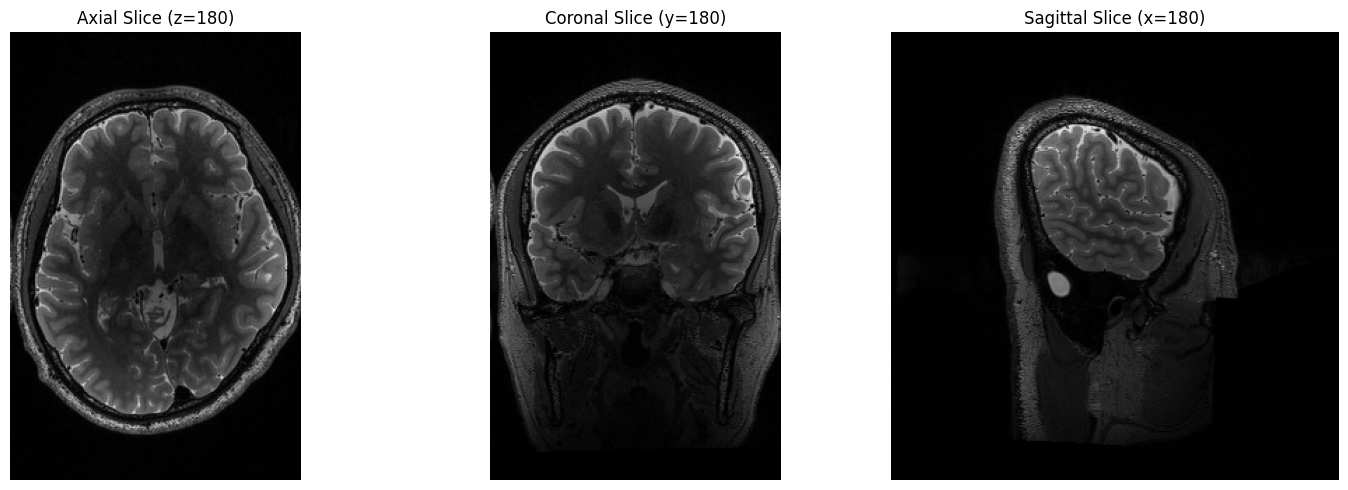

In [25]:
# 180th slice along all the axis for T1

# Axial plane 
axial_slice = ndi.rotate(T2_sub1[:, :, 180], 90)

# Coronal plane 
coronal_slice = ndi.rotate(T2_sub1[:, 180, :], 90)

# Sagittal plane 
sagittal_slice = ndi.rotate(T2_sub1[180, :, :], 90)

# Plot all three slices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(axial_slice, cmap="gray")
axes[0].set_title("Axial Slice (z=180)")
axes[0].axis("off")

axes[1].imshow(coronal_slice, cmap="gray")
axes[1].set_title("Coronal Slice (y=180)")
axes[1].axis("off")

axes[2].imshow(sagittal_slice, cmap="gray")
axes[2].set_title("Sagittal Slice (x=180)")
axes[2].axis("off")

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

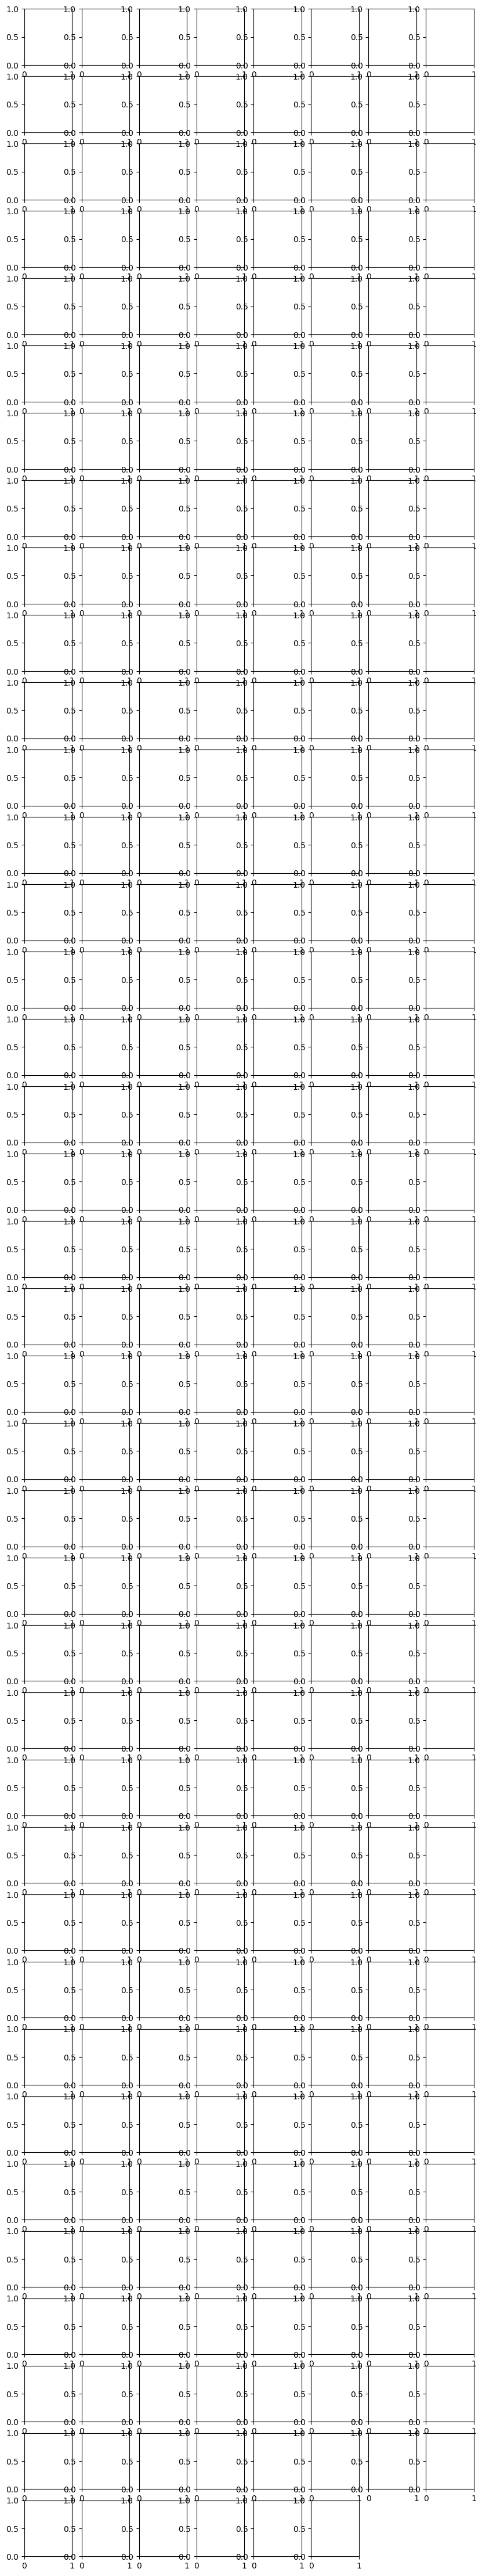

In [26]:
# All the slices along the axial plane
fig, ax = plt.subplots(40,8,figsize=(10,60))
ax = ax.flatten()
for i in range(0,320):
    ax[i].imshow(ndi.rotate(T2_sub1[:,:,i],90), cmap = 'gray')
    ax[i].axis('off')
    ax[i].set_title(i)
    

# 2. Post-processing 

# Skull stripping

In [8]:
import os
folder = (r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat")
for i in os.listdir(folder):
    if i.endswith(".nii.gz"):
        bet = fsl.BET(in_file=(r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/" + i), out_file=f'/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/{i}.nii', mask=False)
        bet.run()

251101-07:24:19,546 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI
251101-07:24:23,426 nipype.interface WARNING:
	 FSLOUTPUTTYPE environment variable is not set. Setting FSLOUTPUTTYPE=NIFTI


In [9]:
SkullStripped_T1 = nib.load(r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/sub-04_ses-1_T1w_defaced.nii").get_fdata()

In [10]:
SkullStripped_T1.shape

(208, 320, 320)

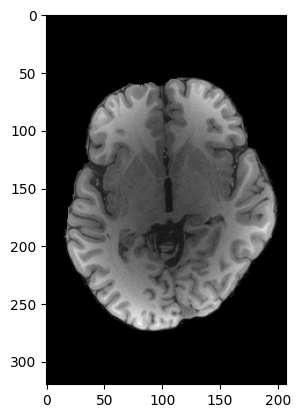

In [12]:
plt.imshow(ndi.rotate(SkullStripped_T1[:,:,180], 90), cmap = 'gray')

In [13]:
SkullStripped_T2 = nib.load(r"/mnt/c/Users/barsa/Downloads/Healthy/23706033/dataset/dataset/Nifti/sub-04/ses-1/anat/sub-04_ses-1_T2w_defaced.nii").get_fdata()

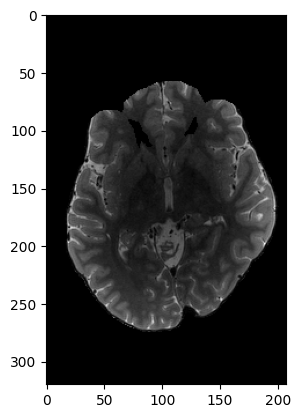

In [14]:
plt.imshow(ndi.rotate(SkullStripped_T2[:,:,180], 90), cmap = 'gray')

# Intensity Normalization

In [44]:
# Check range of Intensities for each MR Image

T1_max = np.amax(T1_sub1)
T1_min = np.amin(T1_sub1)
T2_max = np.amax(T2_sub1)
T2_min = np.amin(T2_sub1)

print("T1_max:" ,T1_max, "T1_min:", T1_min, "T2_max:", T2_max, "T2_min:", T2_min)

T1_max: 4095.0000143051147 T1_min: 0.0 T2_max: 3894.999892283231 T2_min: 0.0


In [45]:
# Check range of Intensities for each MR Image

T1_max_SS = np.amax(SkullStripped_T1)
T1_min_SS = np.amin(SkullStripped_T1)
T2_max_SS = np.amax(SkullStripped_T2)
T2_min_SS = np.amin(SkullStripped_T2)

print("T1_max_SS:" ,T1_max_SS, "T1_min_SS:", T1_min_SS, "T2_max_SS:", T2_max_SS, "T2_min_SS:", T2_min_SS)

T1_max_SS: 2976.006103515625 T1_min_SS: 0.0 T2_max_SS: 3351.00146484375 T2_min_SS: 0.0


Intensity Normalization in -1 to 1 range

In [46]:

T1_sub1_IM1 = (T1_sub1.astype(np.float32) - np.amax(T1_sub1/2)) / np.amax(T1_sub1/2) 
T2_sub1_IM1 = (T2_sub1.astype(np.float32) - np.amax(T2_sub1/2)) / np.amax(T2_sub1/2) 
SkullStripped_T1_IM1 = (SkullStripped_T1.astype(np.float32) - np.amax(SkullStripped_T1/2)) / np.amax(SkullStripped_T1/2) 
SkullStripped_T2_IM1 = (SkullStripped_T2.astype(np.float32) - np.amax(SkullStripped_T2/2)) / np.amax(SkullStripped_T2/2) 

print ("T1_sub1_IM1_min:", np.amin(T1_sub1_IM1), "T1_sub1_IM1_max:", np.amax(T1_sub1_IM1), 
       "T2_sub1_IM1_min:", np.amin(T2_sub1_IM1), "T2_sub1_IM1_max:", np.amax(T2_sub1_IM1),
       "SkullStripped_T1_IM1_min:", np.amin(SkullStripped_T1_IM1), "SkullStripped_T1_IM1_max:", np.amax(SkullStripped_T1_IM1),
       "SkullStripped_T2_IM1_min:", np.amin(SkullStripped_T2_IM1), "SkullStripped_T2_IM1_max:", np.amax(SkullStripped_T2_IM1))


T1_sub1_IM1_min: -1.0 T1_sub1_IM1_max: 0.9999999930133749 T2_sub1_IM1_min: -1.0 T2_sub1_IM1_max: 1.0000000553102808 SkullStripped_T1_IM1_min: -1.0 SkullStripped_T1_IM1_max: 1.0 SkullStripped_T2_IM1_min: -1.0 SkullStripped_T2_IM1_max: 1.0


Intensity Normalization in 0 to 1 range

In [43]:

T1_sub1_IM2 = (T1_sub1-np.min(T1_sub1))/(np.max(T1_sub1)-np.min(T1_sub1))
T2_sub1_IM2 = (T2_sub1-np.min(T2_sub1))/(np.max(T2_sub1)-np.min(T2_sub1))
SkullStripped_T1_IM2 = (SkullStripped_T1-np.min(SkullStripped_T1))/(np.max(SkullStripped_T1)-np.min(SkullStripped_T1))
SkullStripped_T2_IM2 = (SkullStripped_T2-np.min(SkullStripped_T2))/(np.max(SkullStripped_T2)-np.min(SkullStripped_T2))

print ("T1_sub1_IM2_min:", np.amin(T1_sub1_IM2), "T1_sub1_IM2_max:", np.amax(T1_sub1_IM2), 
       "T2_sub1_IM2_min:", np.amin(T2_sub1_IM2), "T2_sub1_IM2_max:", np.amax(T2_sub1_IM2),
       "SkullStripped_T1_IM2_min:", np.amin(SkullStripped_T1_IM2), "SkullStripped_T1_IM2_max:", np.amax(SkullStripped_T1_IM2),
       "SkullStripped_T2_IM2_min:", np.amin(SkullStripped_T2_IM2), "SkullStripped_T2_IM2_max:", np.amax(SkullStripped_T2_IM2))


T1_sub1_IM2_min: 0.0 T1_sub1_IM2_max: 1.0 T2_sub1_IM2_min: 0.0 T2_sub1_IM2_max: 1.0 SkullStripped_T1_IM2_min: 0.0 SkullStripped_T1_IM2_max: 1.0 SkullStripped_T2_IM2_min: 0.0 SkullStripped_T2_IM2_max: 1.0


# 3. Subtraction and Addition maps of T1 and T2

In [79]:
T1_SubtractionMap =T1_sub1[:,:,185] - T2_sub1[:,:,185] 
T2_SubtractionMap = T2_sub1[:,:,185] - T1_sub1[:,:,185] 

T1_SubtractionMap_SS = SkullStripped_T1_IM1[:,:,185]  - SkullStripped_T2_IM1[:,:,185] 
T2_SubtractionMap_SS = SkullStripped_T2_IM1[:,:,185]  - SkullStripped_T1_IM1[:,:,185]  


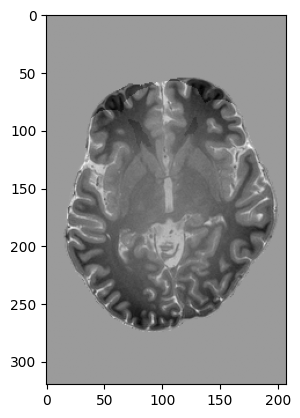

In [68]:
plt.imshow(ndi.rotate(T2_SubtractionMap, 90), cmap = 'gray')

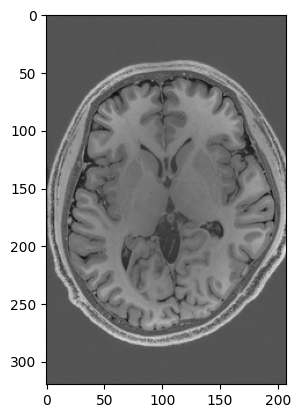

In [71]:
plt.imshow(ndi.rotate(T1_SubtractionMap, 90), cmap = 'gray')

(np.float64(-0.5), np.float64(207.5), np.float64(319.5), np.float64(-0.5))

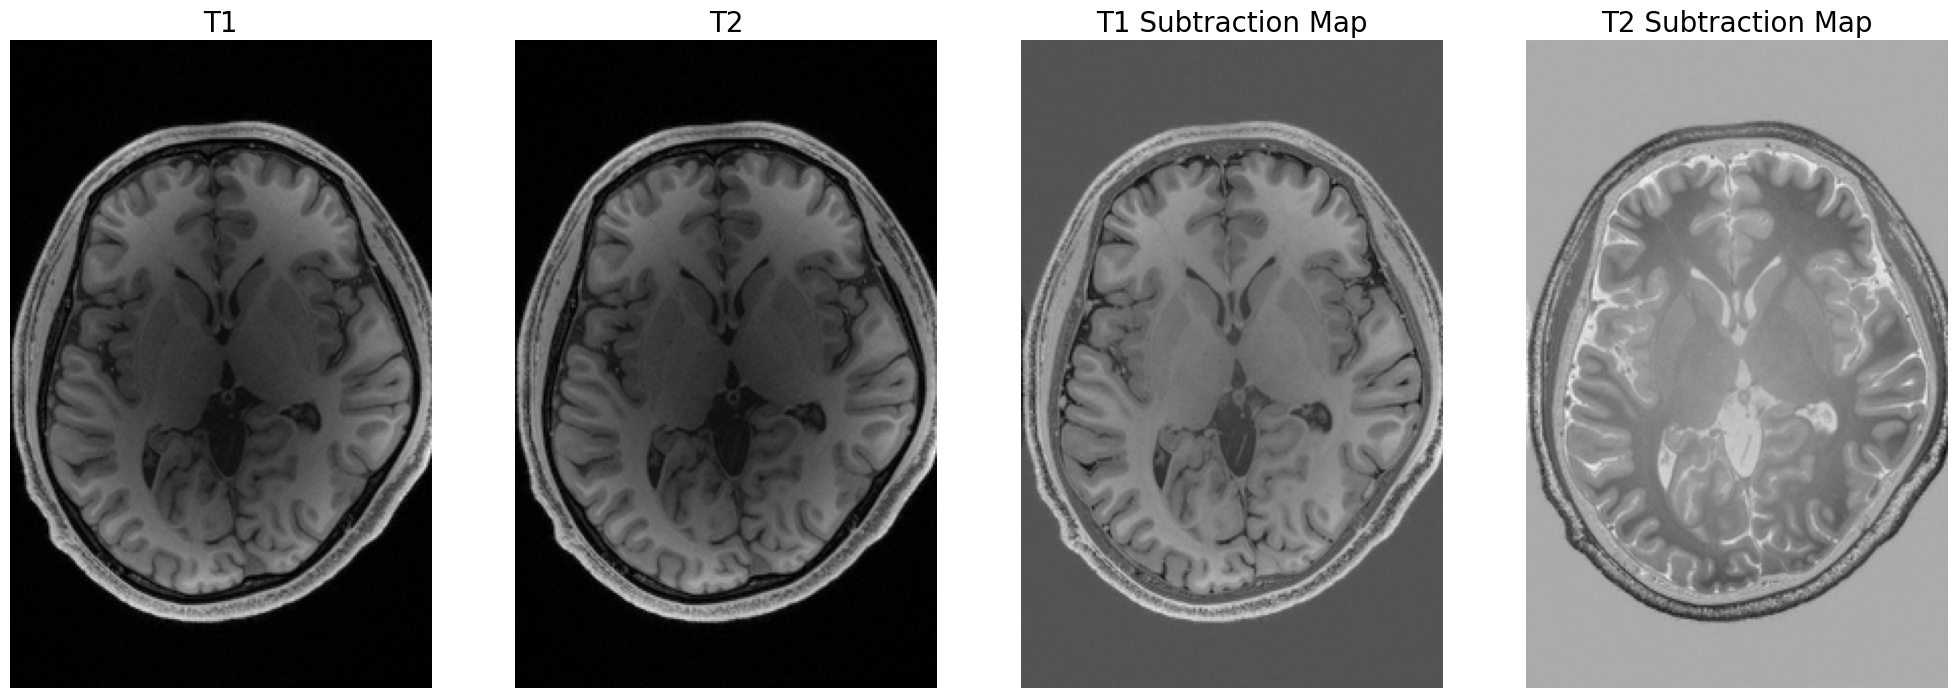

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(25,25))
#fig, ax = plt.subplots(2, 2)

#plt.figure(figsize=(30,30))
# Show an image in each subplot
ax[0].imshow(ndi.rotate(T1_sub1[:,:,185], 90), cmap = "gray") #row=0, col=0
ax[0].set_title('T1', fontsize = 20)
ax[0].axis('off')
ax[1].imshow(ndi.rotate(T1_sub1[:,:,185], 90), cmap = 'gray') #row=1, col=0
ax[1].set_title('T2', fontsize = 20)
ax[1].axis('off')
ax[2].imshow(ndi.rotate(T1_SubtractionMap,90), cmap = "gray") #row=1, col=0
ax[2].set_title('T1 Subtraction Map', fontsize = 20)
ax[2].axis('off')
ax[3].imshow(ndi.rotate(T2_SubtractionMap,90), cmap = "gray") #row=1, col=0
ax[3].set_title('T2 Subtraction Map', fontsize = 20)
ax[3].axis('off')

(np.float64(-0.5), np.float64(207.5), np.float64(319.5), np.float64(-0.5))

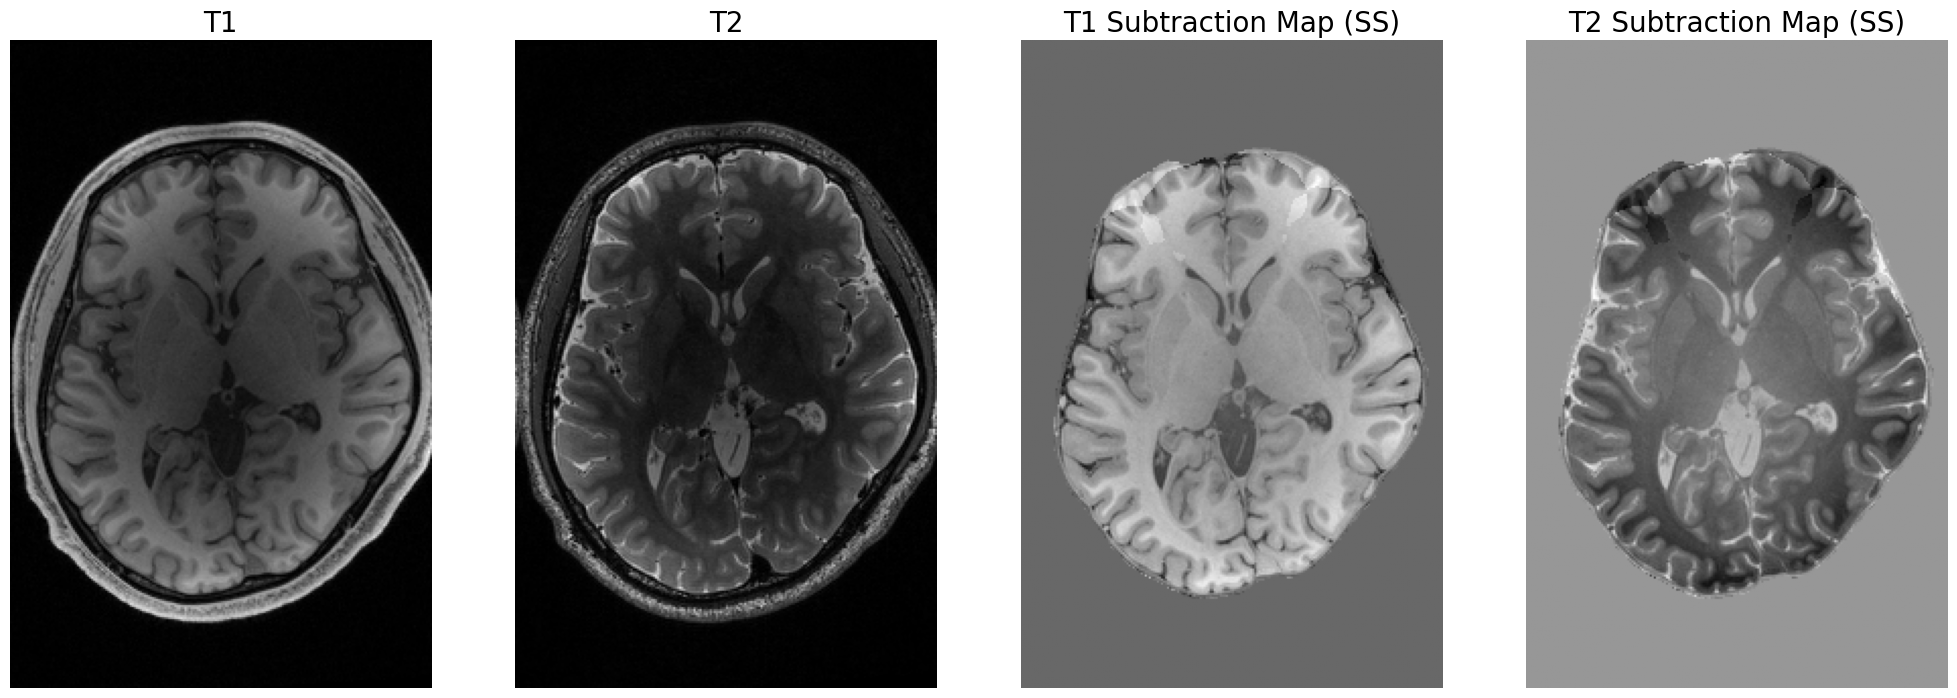

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(25,25))
#fig, ax = plt.subplots(2, 2)


#plt.figure(figsize=(30,30))
# Show an image in each subplot
ax[0].imshow(ndi.rotate(T1_sub1[:,:,185], 90), cmap = "gray") #row=0, col=0
ax[0].set_title('T1', fontsize = 20)
ax[0].axis('off')
ax[1].imshow(ndi.rotate(T2_sub1[:,:,185], 90), cmap = 'gray') #row=1, col=0
ax[1].set_title('T2', fontsize = 20)
ax[1].axis('off')
ax[2].imshow(ndi.rotate(T1_SubtractionMap_SS,90), cmap = "gray") #row=1, col=0
ax[2].set_title('T1 Subtraction Map (SS)', fontsize = 20)
ax[2].axis('off')
ax[3].imshow(ndi.rotate(T2_SubtractionMap_SS,90), cmap = "gray") #row=1, col=0
ax[3].set_title('T2 Subtraction Map (SS)', fontsize = 20)
ax[3].axis('off')

# 4. Compare Intensity and Contrast between Images

Synthetic Image Distribution Slope: -0.3636
T1GD Image Distribution Slope: -0.7004
Difference in Slope: -0.3368


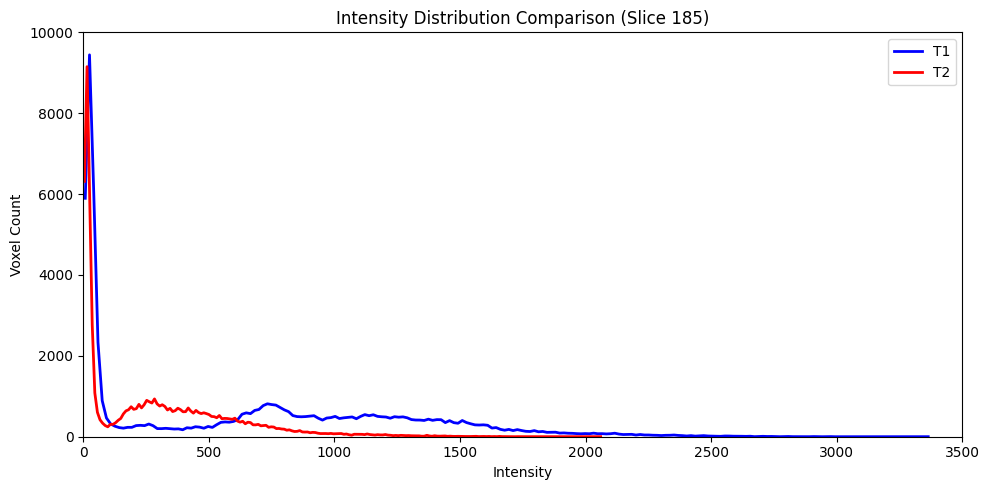

In [94]:

# Compare Intensity between T1 and T2
bins = 200
# === Remove non-finite values for histogram ===
T1_flat = T1_sub1[:,:,185][np.isfinite(T1_sub1[:,:,185])]
T2_flat = T2_sub1[:,:,185][np.isfinite(T2_sub1[:,:,185])]

# === Compute histograms ===
counts_T1, bins_T1 = np.histogram(T1_flat, bins=bins)
centers_T1 = (bins_T1[:-1] + bins_T1[1:]) / 2

counts_T2, bins_T2 = np.histogram(T2_flat, bins=bins)
centers_T2 = (bins_T2[:-1] + bins_T2[1:]) / 2

# === Linear regression (slope) ===
slope_T1, _, _, _, _ = linregress(centers_T1, counts_T1)
slope_T2, _, _, _, _ = linregress(centers_T2, counts_T2)

print(f"Synthetic Image Distribution Slope: {slope_T1:.4f}")
print(f"T1GD Image Distribution Slope: {slope_T2:.4f}")
print(f"Difference in Slope: {slope_T2 - slope_T1:.4f}")

# === Plot both histograms together ===
plt.figure(figsize=(10, 5))
plt.plot(centers_T1, counts_T1, label='T1', color='blue', linewidth=2)
plt.plot(centers_T2, counts_T2, label='T2', color='red', linewidth=2)

plt.title(f'Intensity Distribution Comparison (Slice {185})')
plt.xlabel('Intensity')
plt.ylabel('Voxel Count')
plt.ylim(0, 10000)
plt.xlim(0, 3500)
plt.legend()
plt.grid(False)
plt.tight_layout()

# Optional: save the figure
# plt.savefig("/home/barsa/Brain_MRI/modified_img/new_imgs/TCGA-06-0145_E12_vs_T1GD.jpg")

plt.show()

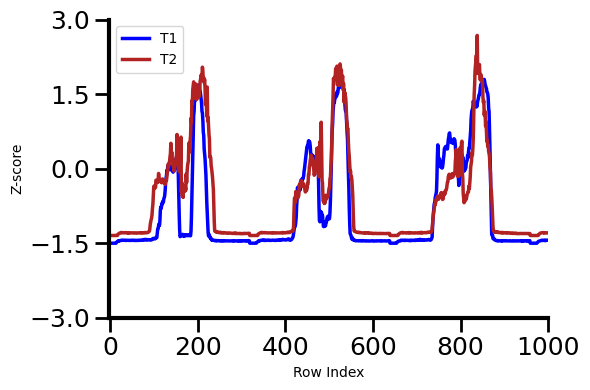

Correlation (Contrast): 0.9027


In [106]:
# Compare Contrast between T1 and T2

# Function to customize plot aesthetics
import matplotlib.ticker as plticker
def customize_axes(ax):
    # Hide top and left spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Show and thicken right and bottom spines
    ax.spines['left'].set_linewidth(3)
    ax.spines['bottom'].set_linewidth(3)

    # Move ticks to right and bottom only
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Increase tick width and length
    ax.tick_params(width=2, length=10)
    ax.tick_params(axis='both', labelsize=18)
    ax.xaxis.set_major_locator(plticker.MultipleLocator(200))
    ax.yaxis.set_major_locator(plticker.MultipleLocator(1.5))
    
# Assuming img1 and img2 are already loaded grayscale images of the same shape

img1 = T1_sub1
img2 = T2_sub1

# Compute row-wise luminance and contrast
row_contrast_1 = np.std(img1, axis=1)
row_contrast_2 = np.std(img2, axis=1)

# Normalize using z-score
scaler = StandardScaler()
contrast1_norm = scaler.fit_transform(row_contrast_1.reshape(-1, 1)).flatten()
contrast2_norm = scaler.fit_transform(row_contrast_2.reshape(-1, 1)).flatten()

# Plot normalized contrast
plt.figure(figsize=(6, 4), facecolor='none')
ax2 = plt.gca()
plt.plot(contrast1_norm, label='T1', color='blue', linewidth = 2.5)
plt.plot(contrast2_norm, label='T2', color='firebrick', linewidth = 2.5)
# plt.title('Normalized Row-wise Contrast Comparison')
plt.ylim(-3, 3)
plt.xlim(-2,1000)
plt.xlabel('Row Index')
plt.ylabel('Z-score')
plt.legend()
plt.grid(False)
customize_axes(ax2)
plt.tight_layout()
plt.rcParams['savefig.transparent'] = True
# plt.savefig('/home/barsa/Brain_MRI/modified_img/lum_cont_int/TCGA-DU-8168_contrast_comparisonte02VST1Gd.png', dpi = 600, bbox_inches = 'tight', transparent = True)
plt.show()

# Correlation coefficients
contrast_corr = np.corrcoef(contrast1_norm, contrast2_norm)[0, 1]

print(f"Correlation (Contrast): {contrast_corr:.4f}")
